<h1 style="font-size:30px;">Gradient Descent for Optimization</h1>

<img src="https://opencv.org/wp-content/uploads/2023/05/c3_w1_gradient_descent_demo.gif">

In this notebook, we will use a simple example to demonstrate an algorithm called **Gradient Descent**. Gradient descent is a gradient-based optimization algorithm that is used extensively in machine learning and deep learning to minimize a loss function by iteratively adjusting the model parameters in the direction of steepest descent based on the negative gradient. Specifically, we will look at how to fit a straight line through a set of points to determine the slope of the line. To do this, we will define a loss function that quantifies the error between the data and the mathematical model we choose to represent the data, and we will use this loss function to develop an update rule that will iteratively converge to the optimal value. We will conclude the notebook with a variation on the Gradient Descent algorithm called **Mini-Batch Stochastic Gradient Descent** which is the basis for training neural networks.

**Note**: This notebook could also be coded entirely with Python and NumPy, but we will start using basic PyTorch tensors and methods to introduce the framework.

## Table of Contents
* [1 Create Some Data](#1-Create-Some-Data)
* [2 Define a Model for the Data](#2-Define-a-Model-for-the-Data)
* [3 Define a Loss Function](#3-Define-a-Loss-Function)
* [4 Optimization](#4-Optimization)
    * [4.1 Brute Force Search](#4.1-Brute-Force-Search)
    * [4.2 Gradient Descent](#4.2-Gradient-Descent)
    * [4.3 Stochastic Gradient Descent](#4.3-Stochastic-Gradient-Descent)
    * [4.4 Stochastic Gradient Descent with Mini-Batch](#4.4-Stochastic-Gradient-Descent-with-Mini\-Batch)
* [5 Automatic Differentiation with Autograd](#5-Automatic-Differentiation-with-Autograd)
    * [5.1 Using Autograd](#5.1-Using-Autograd)
    * [5.2 Gradient Descent with Autograd](#5.2-Gradient-Descent-with-Autograd)

In [1]:
# Import necessary libraries
import torch                     # PyTorch for tensors and deep learning utilities
import numpy as np               # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting

# Use the 'ggplot' style for plots (gives plots a clean, grid-based style)
plt.style.use('ggplot')

# Enable inline plotting (Jupyter/IPython only).
# This makes plots display directly in the notebook.
%matplotlib inline

# Set default figure size for all plots to be wide (15x6 inches).
plt.rcParams["figure.figsize"] = (15, 6)

# Set default font size for axis titles and labels.
plt.rcParams['axes.titlesize'] = 16   # Title font size
plt.rcParams['axes.labelsize'] = 14   # Axis label


## 1 Create Some Data

In [2]:
def create_data(num_data=30):
    # Set Random manual seed for consistency.
    torch.manual_seed(42)
    # Create some data that is roughly linear (but not exactly).
    x = 10 * torch.rand(num_data)
    y = x + torch.randn(num_data) * 0.3

    return x, y

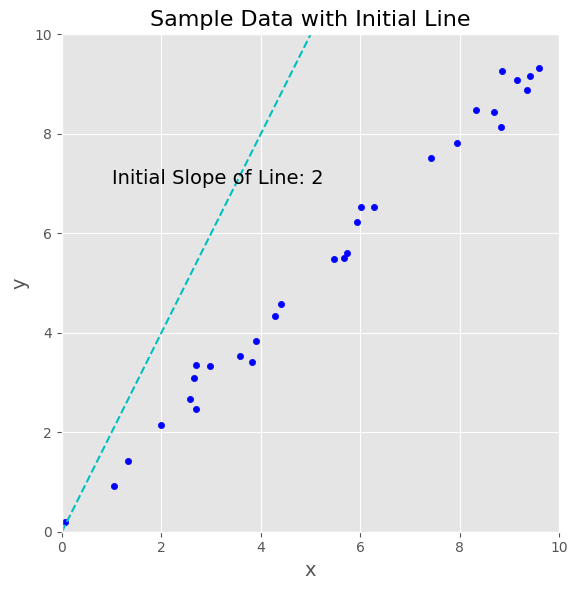

In [3]:
# Create some data (x, y)
x, y = create_data()

# Line with slope m0 (draw it within the 0–10 window to avoid autoscaling surprises)
m0 = 2
xplot = np.array([0.0, 10.0])     # keep the line segment inside the shown range
yplot = m0 * xplot

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(6, 6))  # square figure

ax.scatter(x, y, color='blue', s=20)    # sample points
ax.plot(xplot, yplot, 'c--')            # initial line (slope m0)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Sample Data with Initial Line')
ax.text(1, 7, f'Initial Slope of Line: {m0}', fontsize=14)

# Show only 0..10 on both axes
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Force equal data scaling WITHOUT changing the limits
ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()


## 2 Define a Model for the Data

Our model for the data is a straight line, and we will simplify the problem so that the line passes through the origin. The equation for such a line is:

$$y = mx$$

The model has a single unknown parameter $m$ (the slope of the line) that we wish to compute.

## 3 Define a Loss Function

Let's now define a **loss** function that quantifies the error between our model and any particular data point. For any given value of $x_i$ in our dataset, we have the corresponding value for $y_i$ as well as an estimate given by $mx_i$. So, we will have an error or a residual given by:

$$
e_i = (y_i - m x_i)
$$

We want to find a value of $m$ that minimizes the error above. Positive or negative values of error are equally bad for us. So if we square the error, we can define a loss metric that equally measures errors in either direction (above or below the line). The line that best fits the dataset as a whole would minimize the total loss across the entire dataset, so we want to sum the errors for every point in the dataset. In other words, we want to minimize the following equation:

$$
l = \sum^n_{i=1}(y_i - m x_i)^2 \\
$$

This is known as the **sum of squared errors** loss function. If we compute the average squared loss across the entire dataset then we arrive at the mean squared error (MSE) loss function below:

$$
l = \frac{1}{n}\sum^n_{i=1}(y_i - m x_i)^2 \\
$$

Another variation for loss is mean absolute error (MAE) that is given by:


$$
l = \frac{1}{n}\sum^n_{i=1}|y_i - m x_i| \\
$$

A key difference between MSE and MAE is that the MSE loss function is more sensitive to outliers in the dataset. If you wish to minimize the effect of outliers in the data, then MAE is often a better choice for a loss function because the errors are not squared as they would be with MSE. In the remainder of this notebook we will use the MSE loss function to demonstrate gradient descent. There are other types of loss functions that we'll learn about later in the course.

## 4 Optimization

### 4.1 Brute Force Search

A naive way to find the value of $m$ is to do a brute force search over a large range of $m$ that is known to contain the "best" value for $m$ that minimizes the loss function. The actual value of $m$ that is selected will depend on the granularity of the step size. We save the values of $m$ and the corresponding value for the loss function so that we can plot the results and visualize the loss function.

Minimum Loss:   0.09746846556663513
Best parameter: 0.9795918464660645


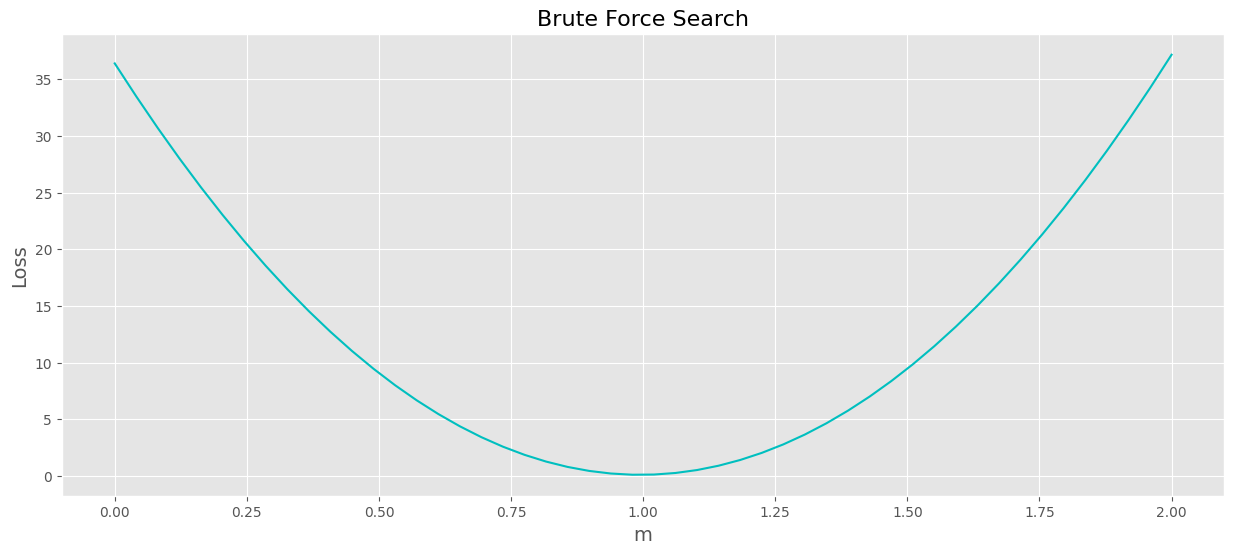

In [4]:
# Minimum value of m
min_val = 0.0

# Maximum value of m
max_val = 2.0

# Number of steps between min and max values
num_steps = 50

# Step size
step_size = (max_val - min_val) / (num_steps - 1)

# Space for storing all values of m
m = torch.zeros(num_steps)

# Space for storing loss corresponding to different values of m.
loss = torch.zeros(num_steps)

# Calculate loss for all possible m
for i in range(num_steps):
    m[i] = min_val + i * step_size
    e = y - m[i] * x
    loss[i] = torch.sum(torch.mul(e, e)) / len(x)


# Find the index for lowest loss
i = torch.argmin(loss)

# Save best slope.
m_best = m[i].numpy()

# Minimum loss.
print(f'Minimum Loss:   {loss[i]}')

# Find the value of m corresponding to lowest loss.
print(f'Best parameter: {m_best}')

# Plot loss vs m.
plt.figure
plt.plot(m.numpy(), loss.numpy(), 'c-')
plt.xlabel('m')
plt.ylabel('Loss')
plt.title("Brute Force Search");

#### <font style="color:rgb(50,120,230)">Compare the Model with the Data</font>

In [5]:
def plot_linear_model(x, y, m_best, xlim=(0, 10), ylim=(0, 10)):
    # Generate the line based on the optimal slope.
    xmin = torch.min(x)
    xmax = torch.max(x)
    ymin = torch.min(y)
    ymax = torch.max(y)

    xplot = np.linspace(xmin.item(), xmax.item(), 2)
    yplot = m_best * xplot

    # Plot the data and the model.
    plt.figure
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot(xplot, yplot, "c-")
    plt.scatter(x, y, color="blue", s=20)
    plt.xlabel("x")
    plt.ylabel("y")
    xc = 0.05 * (xmax - xmin)
    yc = 0.95 * (ymax - ymin)
    plt.text(xc, yc, "Slope: " + str(int(m_best * 1000) / 1000), fontsize=14);

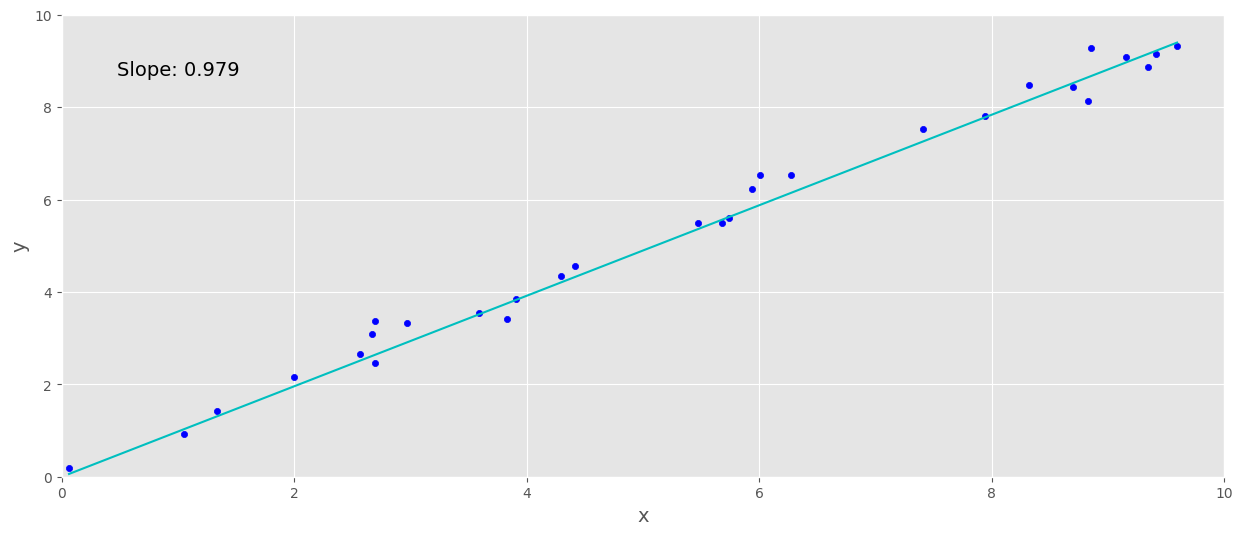

In [6]:
plot_linear_model(x, y, m_best)

### 4.2 Gradient Descent

Let's now discuss how gradient descent works. The 'loss' plot from the previous section shows that we can start from an initial guess of $m$, and follow the slope of the curve downward to reach the bottom of the curve. To automate this process, for a given value of $m$ we can compute the gradient of the loss function and use that value to inform us how to adjust $m$. If the gradient is positive, then we'll need to lower the value of $m$ to move closer to the minimum, and if the gradient is negative, we'll need to raise the value of $m$. This simple idea is called **Gradient Descent**. Assuming the loss function is convex and differentiable, we can calculate the gradient of the loss function with respect to $m$ at any point to accomplish this.

Given the loss function:

$$
\begin{align}
l &= \frac{1}{n}\sum^n_{i=1}(y_i - m x_i)^2 \\
\end{align}
$$

We can compute the gradient of the loss with respect to $m$ using simple calculus:

$$
\begin{align}
\frac{\partial l}{\partial m}  &= \frac{-2}{n} \sum^n_{i=1} x_i(y_i - m x_i) \\
\end{align}
$$


Notice that we're computig the gradient for every point in the dataset, which is why this technique is also referred to as **Batch Gradient Descent** since we are processing a "batch" of data.

We can now use the gradient to develop and update rule for $m$. To follow the slope of the curve toward the minimum, we need to move $m$ in the direction of the negative gradient. However, we need to control the rate at which we move along the curve so that we do not overshoot the minimum. So we use a parameter, $\lambda$, called the **learning rate**. This is a parameter that requires tuning depending on the problem at hand. When working with larger, more complex problems, it can be tricky to set the learning rate appropriately. However, when we start using PyTorch to solve optimization problems, we will have access to very robust optimizers to facilitate this process. Here, we are simply demonstrating the basic concepts.

$$
m_k = m_{k-1} - \lambda \frac{\partial l}{\partial m}
$$

Let's implement this in code to see that it works. Notice in the implementation below we are using all the data points to compute the gradient at each iteration.

In [7]:
# Parameter settings.
num_iter0 = 50
lr0 = 0.005

# Initial guess for m.
m0 = 2

max_loss = 30.0  # For plot scale.

Best iteration:  28
Minimum loss:    0.089013815
Best parameter:  0.9947721


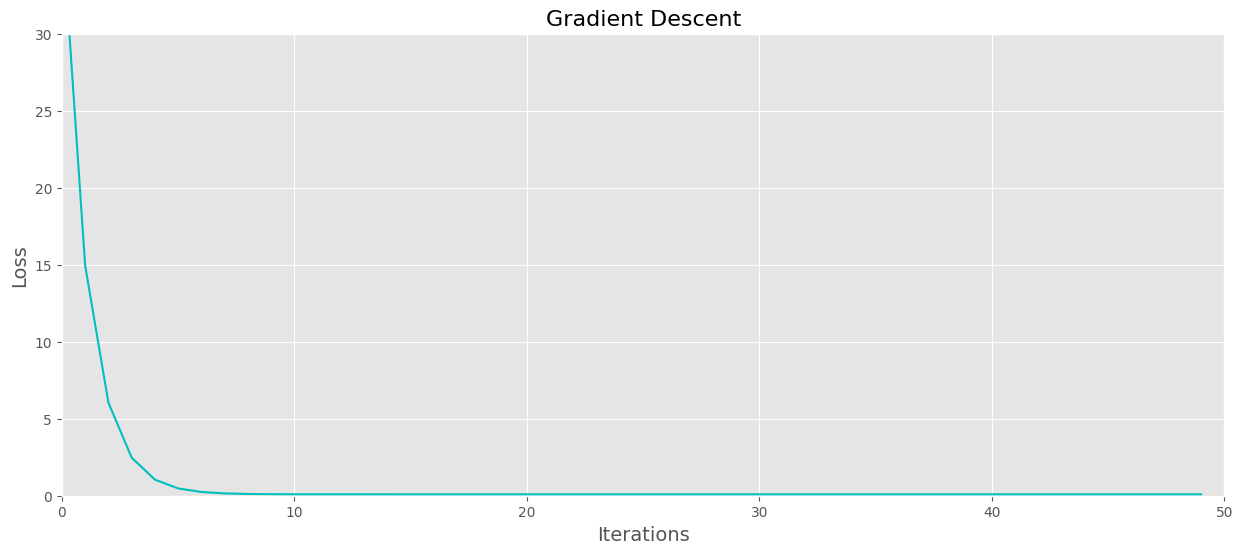

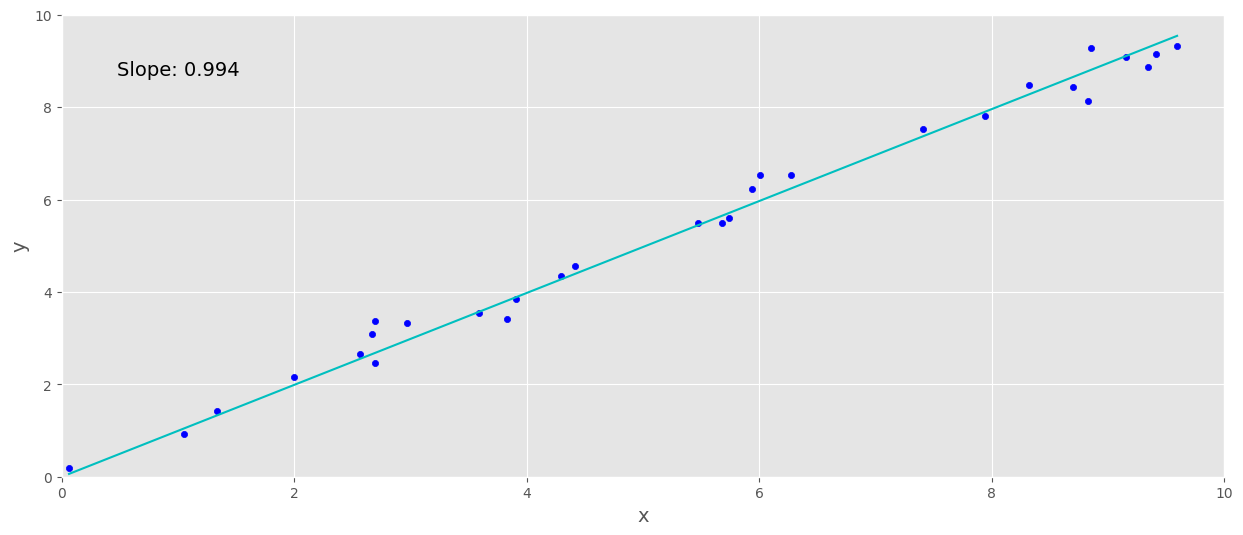

In [8]:
num_iter = num_iter0
lr = lr0
m = m0

# For collecting intermediate losses.
loss_gd = torch.zeros(num_iter)

# Slope history.
slopes = torch.zeros(num_iter)

# Calculate the loss.
for i in range(num_iter):
    # Compute the avearge loss of the entire dataset.
    e = y - m * x
    loss_gd[i] = torch.sum(torch.mul(e, e)) / len(x)

    # Compute the average gradient of the entire dataset.
    g = -2.0 * torch.sum(x * e) / len(x)

    # Update the parameter 'm'.
    m = m - lr * g
    slopes[i] = m


# Get the best loss and the corresponding slope value.
loss_best, index = torch.min(loss_gd, 0)
m_best = slopes[index].numpy()

print("Best iteration: ", index.numpy())
print("Minimum loss:   ", loss_best.numpy())
print("Best parameter: ", m_best)

# Plot loss vs m
plt.figure
plt.plot(loss_gd.numpy(), "c-")
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Gradient Descent")
plt.show()

plot_linear_model(x, y, m_best)

### 4.3 Stochastic Gradient Descent

In this example, we have only a handful of data points. In the real world, we can have millions of examples. Calculating the gradient based on all data points can be computationally expensive. Fortunately, using all the data points for computing the gradient is unnecessary.

We can use a **single** randomly chosen data point to compute the gradient at each iteration. Even though the gradient at each step is not as accurate, the idea still works. The convergence might be slower using this technique because the gradient is not as accurate. In the next section, we will extend this idea to use a small percentage of the data to better approximate the gradient yet limit the number of computations.

Final loss:       0.13655618
Final parameter:  0.9608304


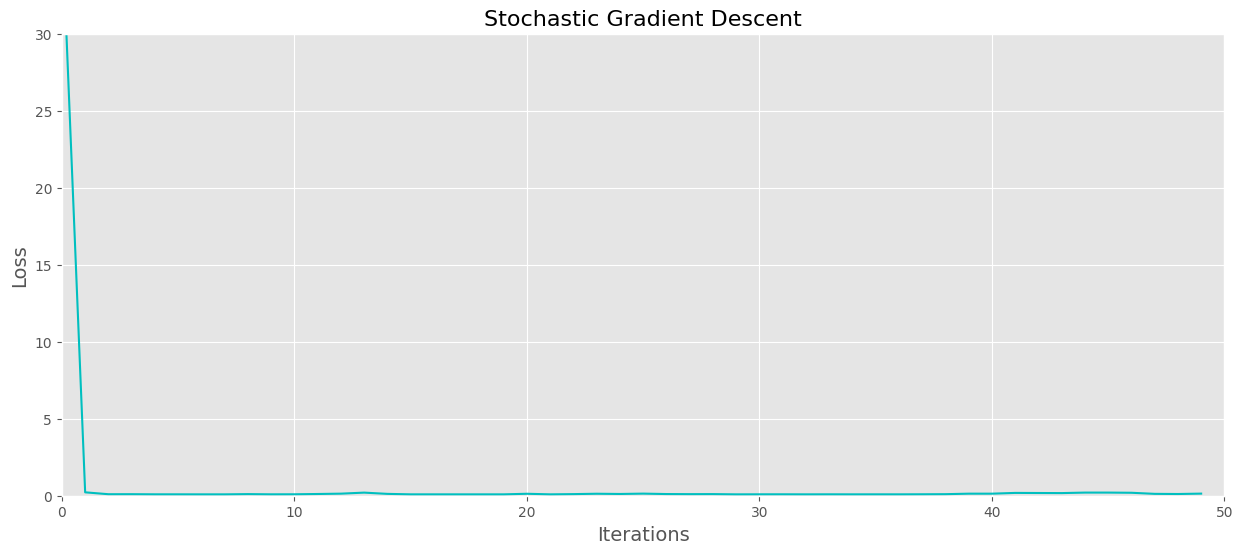

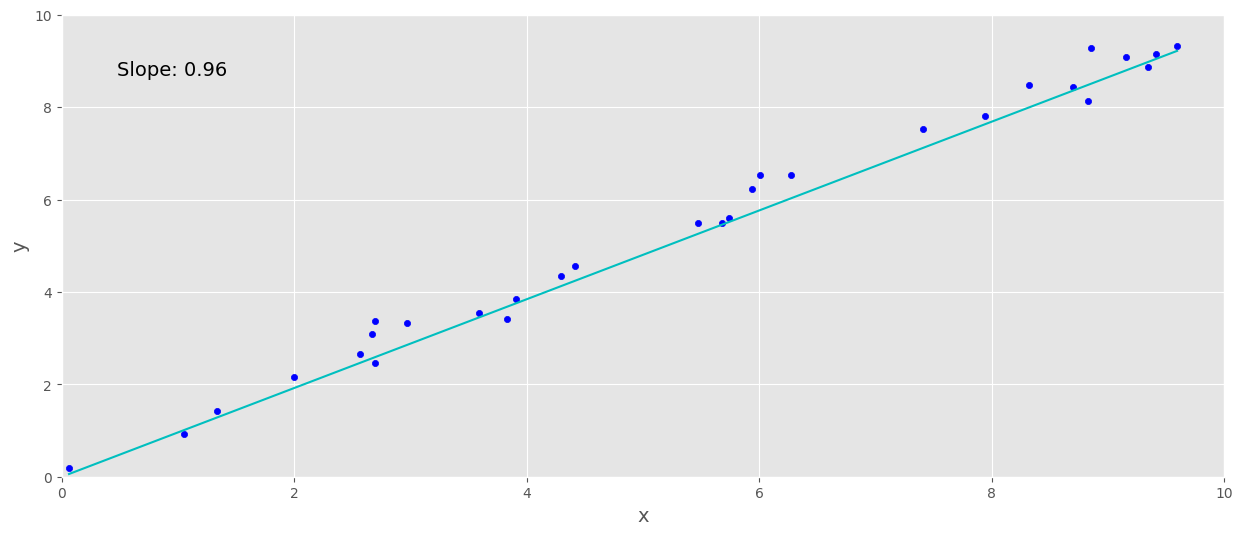

In [9]:
num_iter = num_iter0
lr = lr0
m = m0

# For collecting intermediate losses.
loss_sgd = torch.zeros(num_iter)

for i in range(0, num_iter):
    # Randomly select a training data point
    k = torch.randint(0, len(y), (1,))[0]

    # Compute the avearge loss of the entire dataset.
    e = y - m * x
    loss_sgd[i] = torch.sum(torch.mul(e, e)) / len(x)

    # Calculate gradient using a single data point.
    g = -2.0 * x[k] * (y[k] - m * x[k])

    # Update the parameter 'm'.
    m = m - lr * g

m_final = m.numpy()  # Current parameter value

print("Final loss:      ", loss_sgd[-1].numpy())
print("Final parameter: ", m_final)

# Plot loss vs m
plt.figure
plt.plot(loss_sgd.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Stochastic Gradient Descent')
plt.show();

plot_linear_model(x, y, m_final)

### 4.4 Stochastic Gradient Descent with Mini-Batch

In the previous section, we saw that it is possible to calculate the gradient based on a single random data point chosen at each iteration. As long as we execute enough iterations, Stochastic Gradient Descent will still work.

However, using more than one data point for the gradient calculation has two advantages:

1. Using multiple data points produces a more accurate estimate for the gradient.
2. GPUs are highly efficient at processing gradient computations.

So, we get better results and faster convergence if we use a small batch of data points, called a **mini-batch**, to compute the gradients. A "mini-batch" approach strikes a nice balance between using all the data points vs just a single data point.

Let's implement this in code and see for ourselves.

Final loss:       0.04275681
Final parameter:  1.0114044


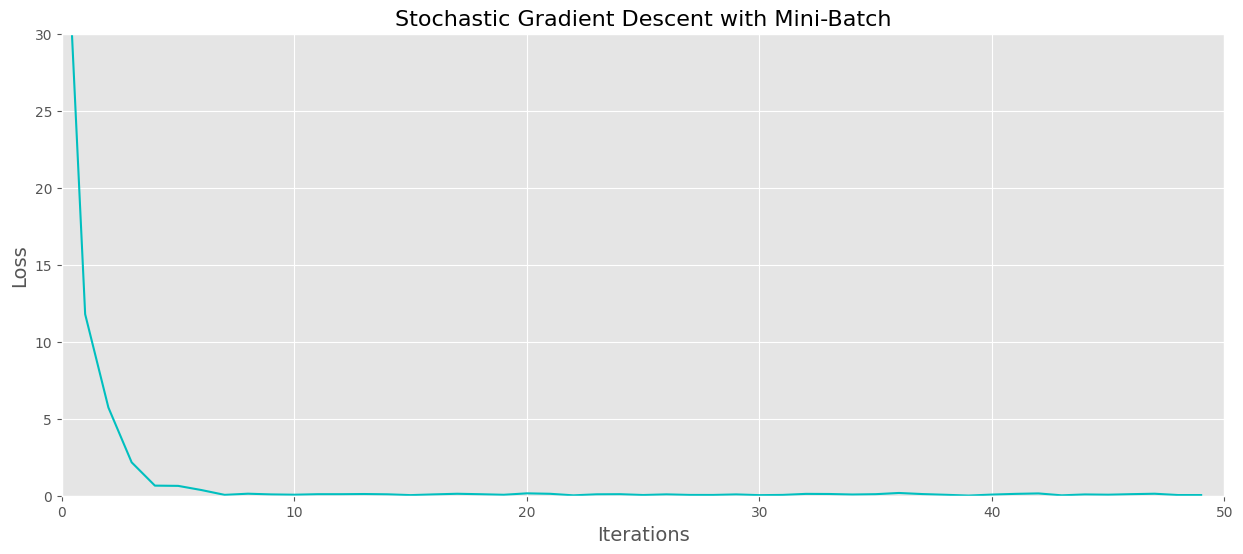

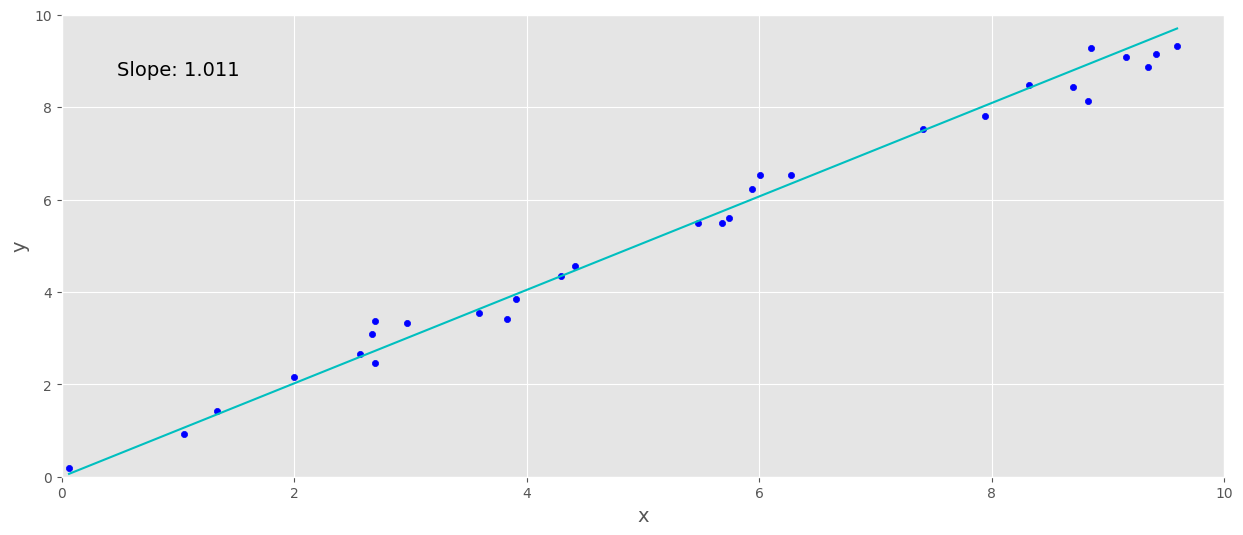

In [10]:
num_iter = num_iter0
lr = lr0
m = m0

batch_size = 10

# For collecting intermediate losses.
loss_sgd_mb = torch.zeros(num_iter)

for i in range(num_iter):
    # Randomly select a batch of data points.
    k = torch.randint(0, len(y), (batch_size,))

    # Compute the loss on a batch of data.
    e = y[k] - m * x[k]
    loss_sgd_mb[i] = torch.sum(torch.mul(e, e)) / batch_size

    # Calculate the gradient using a mini-batch.
    g = (-2.0 / batch_size) * torch.sum(x[k] * (y[k] - m * x[k]))

    # Update the parameter, m.
    m = m - lr * g

m_final = m.numpy()  # Current parameter value

print("Final loss:      ", loss_sgd_mb[-1].numpy())
print("Final parameter: ", m_final)

# Plot loss vs m
plt.figure
plt.plot(loss_sgd_mb.numpy(), 'c-')
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Stochastic Gradient Descent with Mini-Batch')
plt.show();

plot_linear_model(x, y, m_final)

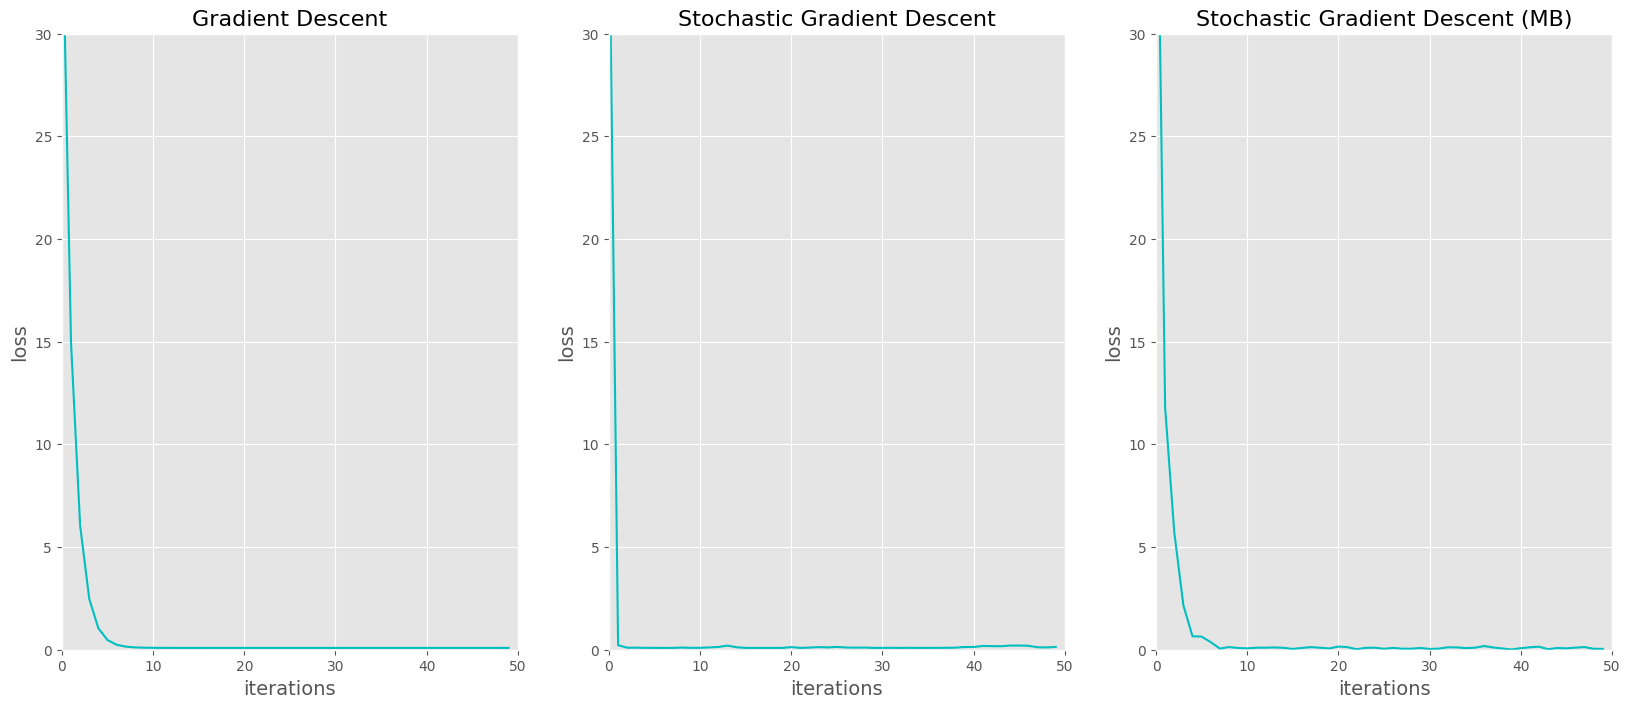

In [11]:
plt.figure(figsize = (20, 8))

plt.subplot(131); plt.plot(loss_gd.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Gradient Descent');

plt.subplot(132); plt.plot(loss_sgd.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Stochastic Gradient Descent');

plt.subplot(133); plt.plot(loss_sgd_mb.numpy(), 'c-'); plt.xlim(0, num_iter); plt.ylim(0, max_loss);
plt.ylabel('loss'), plt.xlabel('iterations'); plt.title('Stochastic Gradient Descent (MB)');

## 5 Automatic Differentiation with `Autograd`

`torch.autograd` is a submodule in PyTorch that provides automatic differentiation capabilities. It is a key component for training deep learning models, as it simplifies the process of computing gradients of tensors with respect to model parameters. These gradients are then used to update the model parameters during the optimization process (e.g., using stochastic gradient descent).

The main uses/features of `torch.autograd` include:

1. **Automatic differentiation:** Builds the graph during the forward pass and computes gradients via the chain rule on `.backward()` (efficient vector–Jacobian products).

2. **Tracking gradients:** Gradients are tracked for any `Tensor` with `requires_grad=True`. We will track the gradients for tensors used for storing model parameters.  

3. **Backward propagation:** Calling .backward() on the loss computes gradients for all tracked parameters.

4. **Gradient accumulation:** PyTorch accumulates gradients in `.grad` of **leaf tensors** (typically model parameters). . That is why we need to clear gradients after each step with `optimizer.zero_grad(set_to_none=True)`.

You can find more information from these official documentations:
1. <a href="https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html" target="_blank">The fundamentals of Autograd</a>
2. <a href="https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html" target="_blank">A Gentle Introduction to `torch.autograd`</a>

**Example 1**

### 5.1 Autograd Examples

In [12]:
# Create a PyTorch tensor with requires_grad flag set to True.
x = torch.tensor(4.0, requires_grad=True)

# Create a new tensor y which equals the square of the x tensor.
# All the operations performed on the "x" tensor are recorded.
y = x ** 2

# Next, the 'autograd' module is used to compute the backward pass.
# The following call will compute the gradient of loss with respect
# to all Tensors with requires_grad=True.
# After this call "x.grad" will hold the gradient dy/dx.
y.backward()

# Print the derivative of y with respect to the input tensor x.
print(f'dy_dx: {x.grad}')

dy_dx: 8.0


**Example 2**

In [13]:
# Create two PyTorch tensors with requires_grad=True
w1 = torch.tensor(5.0, requires_grad=True)
w2 = torch.tensor(3.0, requires_grad=True)

# Perform some mathematical operation using the two tensors.
z = 3 * w1**2 + 2 * w1 * w2

# Use autograd to compute the gradients of the output wrt to the tensors.
z.backward()

# Access and print the gradient values.
print(f"dz_dw1: {w1.grad}")
print(f"dz_dw2: {w2.grad}")

dz_dw1: 36.0
dz_dw2: 10.0


**Example 3**

In [14]:
# Create a 3x5 tensor with random values in [0,1).
# requires_grad=True tells autograd to track all operations on this tensor.
a = torch.rand((3, 5), requires_grad=True)

# Multiply each element of 'a' by 5.
# Since 'a' has requires_grad=True, this operation will be recorded in the computation graph so gradients can be computed later.
result = a * 5

# Print the resulting tensor (still tracked by autograd).
print(result)

# Grad can be implicitly created only for scalar outputs
# so let's calculate the sum here so that the output
# becomes a scalar and we can apply a backward pass
mean_result = result.sum()

# Calculate Gradient
mean_result.backward()

# Access and print the gradient values.
print(f"dz_dw1:\n {a.grad}")

tensor([[2.1900, 3.5174, 0.0546, 3.2425, 0.8470],
        [1.2799, 3.4598, 4.4878, 1.8167, 1.4736],
        [0.2394, 1.2109, 0.3109, 1.9278, 3.0101]], grad_fn=<MulBackward0>)
dz_dw1:
 tensor([[5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.],
        [5., 5., 5., 5., 5.]])



### 5.2 Disabling Autograd for tensors

Suppose there's a scenario where we don't need to compute gradients for all the variables involved in the pipeline. In that case, the PyTorch API provides 2 ways to disable autograd.

1. `detach` - returns a copy of the tensor with autograd disabled. This copy is built on the same memory as the original tensor, so in-place size / stride / storage changes (such as `resize_` / `resize_as_` / `set_` / `transpose_`) modifications are **not** allowed.
1. `torch.no_grad()` - It is a context manager that allows you to guard a series of operations from autograd without creating new tensors.

In [15]:
# Create a 3x5 tensor with values from a normal distribution.
# requires_grad=True means autograd will track computations on this tensor.
a = torch.randn((3, 5), requires_grad=True)

# Create a detached copy of 'a'.
# 'detached_a' shares data with 'a' but does NOT track gradients.
detached_a = a.detach()

# Perform some computations:
detached_result = detached_a * 5   # not tracked by autograd
result = a * 10                    # tracked by autograd

# Backward requires a scalar output. Since 'result' is a matrix,
# we reduce it to a scalar by summing all elements.
mean_result = result.sum()

# Compute gradients of 'mean_result' w.r.t. 'a'.
# This populates 'a.grad' with ∂(10a.sum())/∂a = 10.
mean_result.backward()
print(f"a.grad:\n{a.grad}")

try:
    # Attempting to compute gradients on 'detached_result' will fail
    # because 'detached_a' was created with .detach(), which stopped
    # autograd from tracking it.
    mean_detached_result = detached_result.sum()
    detached_result.backward()  # <-- RuntimeError here
    print(f"detached_result.grad: {detached_result.grad}")
except RuntimeError as e:
    # Expected error: detached tensors are not part of the autograd graph
    print("\n", e)


a.grad:
tensor([[10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10.]])

 element 0 of tensors does not require grad and does not have a grad_fn


### 5.3 Gradient Descent with `autograd`

Let's now do Gradient Descent using autograd. We first create dataset, set the number of iterations, and the learning rate just as before.

In [16]:
# Create data points
x, y = create_data()

# Set number of iterations
num_iter = num_iter0

#Set learning rate
lr = lr0

Next, we set up storage for the model parameter `m` (slope). Note, we are going to use `torch.nn.Parameter` class instead of the plain vanila tensor class.

**Why use `torch.nn.Parameter` instead of a plain Tensor?**

1. *Automatic registration*: Parameters are automatically added to a module’s list of parameters. They show up in model.parameters() so optimizers can update them.

2. `Device management`: When you call .to(device), .cuda(), or .cpu(), all registered parameters move automatically. Plain tensors don’t move unless you handle them manually.

3. `Saving and loading`: Registered parameters are included in model.state_dict(). Plain tensors are not included unless you add them manually.

In [17]:
# Initial guess for m.
m = torch.nn.Parameter(torch.tensor(m0, dtype=torch.float32))

# Storage for loss values over iterations
loss_autograd_gd = torch.zeros(num_iter)

# Storage for slope values over iterations
slopes = torch.zeros(num_iter)

Next we iterate over the data. In each iteration we do the following.

1. Calcuate MSE loss.
2. Backpropagate to calculate the gradient of loss with respect to the parameters (slope).
3. Use the graident to update weights.

To manually update the parameters, the recommended approach is to perform the updates within the `torch.no_grad` context manager to indicate to PyTorch that we shouldn't track, calculate or modify gradients while updating the parameters.

Best iteration:  28
Minimum loss:    0.089013815
Best parameter:  0.9947721


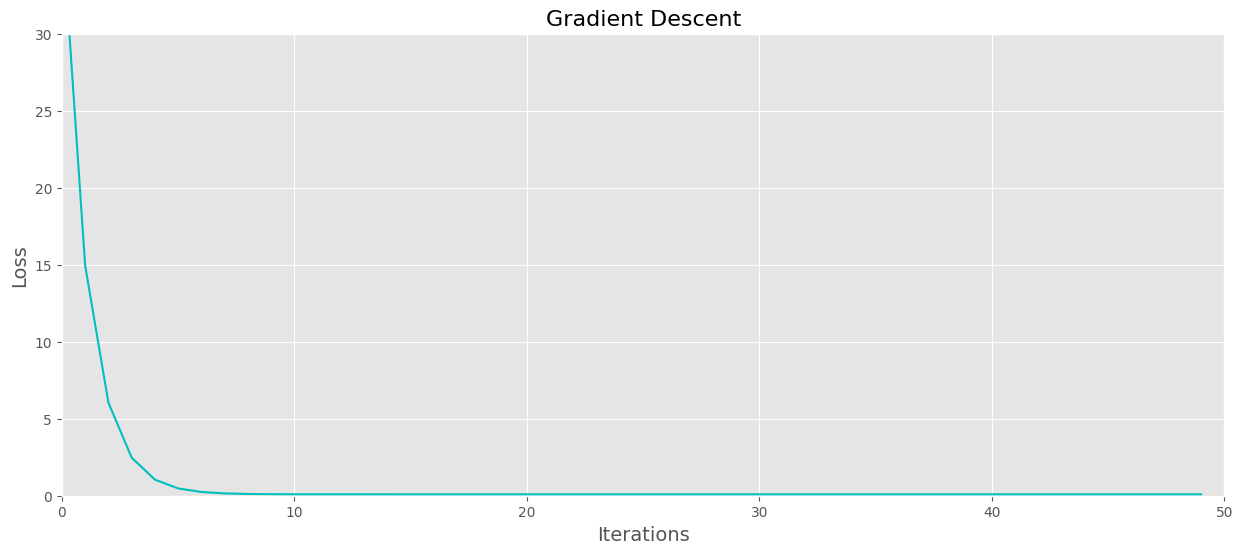

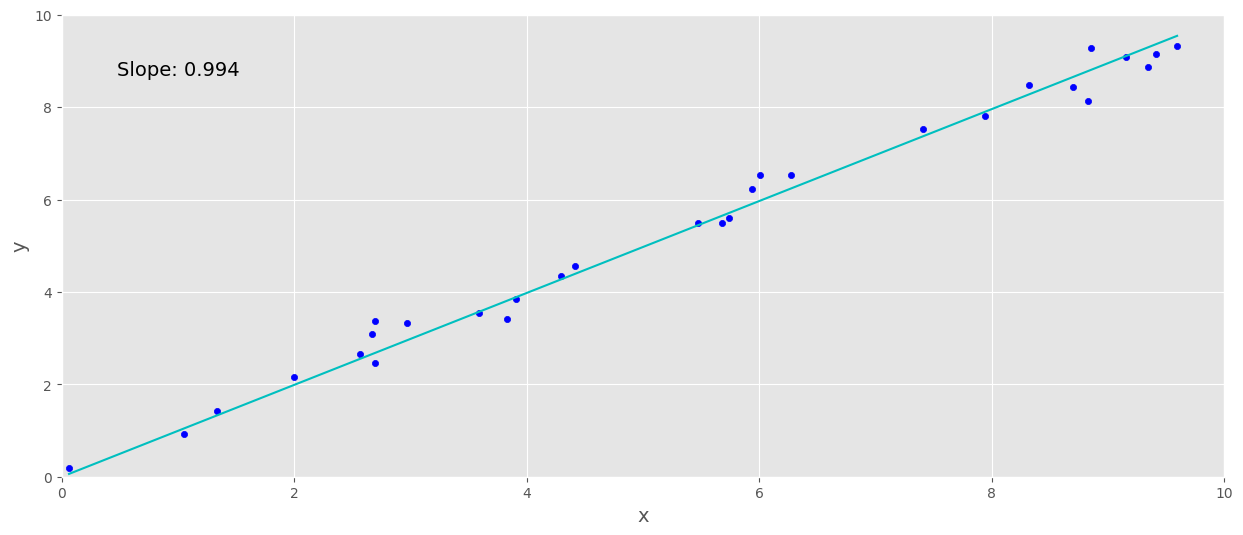

In [18]:
for i in range(num_iter):
    # Compute MSE loss.
    loss = ((y - m * x) ** 2).mean()

    # Automatically compute the gradient of the loss with respect to parameter "m".
    loss.backward()

    # Access the gradient.
    dl_dm = m.grad

    with torch.no_grad():

        # # Perform in-place updates to tensor.
        m -= lr * dl_dm

        # Clear gradients so they do not get accumulated
        # Note: The older style was to use w.grad.zero_(). Use the more efficient m.grad = None instead.
        m.grad = None

    # Track the loss and slope "m" for plotting.
    loss_autograd_gd[i] = loss.detach() # Create a detached clone of "loss".
    slopes[i] = m.detach()              # Create a detached clone of "m".


# Get the best loss and the corresponding slope value.
loss_best, index = torch.min(loss_autograd_gd, 0)
m_best = slopes[index].numpy()

print("Best iteration: ", index.numpy())
print("Minimum loss:   ", loss_best.numpy())
print("Best parameter: ", m_best)

# Plot loss vs m
plt.figure
plt.plot(loss_autograd_gd.numpy(), "c-")
plt.xlim(0, num_iter)
plt.ylim(0, max_loss)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Gradient Descent")
plt.show()

plot_linear_model(x, y, m_best)

## Exercise
Here are a few things that you may try with the above code and have fun!

1. Experiment with the learning rate (make it higher and lower).
2. Experiment with a larger dataset and the size of the mini-batch
3. Try implementing a linear model of the form `y = mx + b`